In [2]:
%matplotlib inline
from config_calc import *
import grid_tools

import matplotlib.pyplot as plt

In [3]:
file_name = '/glade/p/work/mclong/garcia-keeling/o2flux_sea_global.adjusted.20171211.nc'

ds = xr.open_dataset(file_name,decode_times=False,decode_coords=False)

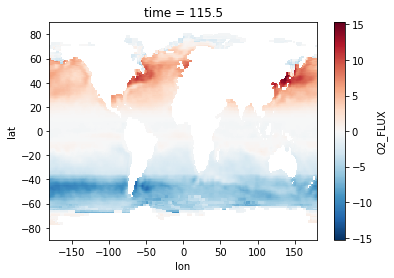

In [13]:
ds.O2_FLUX.isel(time=3).plot()

<xarray.DataArray (time: 12)>
array([ 13.571526,   9.294068,   1.091605,  -5.894607, -10.241765, -12.285197,
       -11.462247,  -8.533144,  -3.482632,   3.755053,  10.617957,  14.112535])
Coordinates:
  * time     (time) float64 26.0 55.5 85.0 115.5 146.0 176.5 207.0 238.0 ...
Attributes:
    long_name:  O$_2$ flux
    units:      mol/m^2/yr

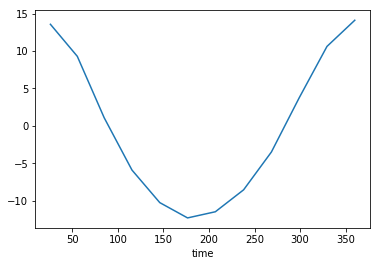

In [8]:
rmask = ds.O2_FLUX.notnull() * ds.area.where((ds.lat<-40)).fillna(0.)
wgt = rmask / rmask.sum(dim=['lon','lat'])
o2 = (ds.O2_FLUX * wgt).sum(dim=['lon','lat'])
o2.attrs['long_name'] = 'O$_2$ flux'
o2.attrs['units'] = ds.O2_FLUX.attrs['units']
o2.plot()

o2

In [7]:
dso.O2_FLUX.isel(time=1).plot()

NameError: name 'dso' is not defined

In [6]:
dsd = ds.O2_FLUX
dsd.values = ds.O2_FLUX.values - dso.O2_FLUX.values
dsd

NameError: name 'dso' is not defined

In [108]:
np.abs(dsd).max()

<xarray.DataArray 'O2_FLUX' ()>
array(2.8879988889229935e-07)

array([   1.,   32.,   60.,   91.,  121.,  152.,  182.,  213.,  244.,
        274.,  305.,  335.])

In [73]:
from datetime import datetime

In [74]:
date = datetime.now()

In [75]:
date.strftime('%Y%m%d')

'20171211'